In [379]:
import pandas as pd
import numpy as np
import warnings
from scipy.stats import skew
import math
import itertools

from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


#adding decision-tree based models
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

#adding linear models
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet


In [218]:
warnings.filterwarnings('ignore')

In [219]:
train_original = pd.read_csv('/Users/mk/Desktop/JupyterNotebooks/Housing Prices/train.csv')
test_original = pd.read_csv('/Users/mk/Desktop/JupyterNotebooks/Housing Prices/test.csv')

train = pd.read_csv('/Users/mk/Desktop/JupyterNotebooks/Housing Prices/train.csv')
test = pd.read_csv('/Users/mk/Desktop/JupyterNotebooks/Housing Prices/test.csv')

In [220]:
#1. Drop Id, set aside SalePrice

train.drop(['Id'], axis = 1 , inplace = True)
test.drop(['Id'], axis = 1, inplace = True)

y_train = train_original['SalePrice']
train.drop(['SalePrice'], axis = 1, inplace = True)



In [221]:
#1a. Check the min and max of the dependent variable, to ensure we can take the log
print(y_train.min(), y_train.max())

y_train = np.log1p(y_train)

y_train.info()

34900 755000
<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: SalePrice
Non-Null Count  Dtype  
--------------  -----  
1460 non-null   float64
dtypes: float64(1)
memory usage: 11.5 KB


In [222]:
#2. Drop any columns with null values in both train and test. 

combo = pd.concat([train, test], axis = 0)

NA = combo.columns[combo.isna().any()].tolist()

combo.drop(NA, axis = 1, inplace = True)

In [223]:
#2a. Check which columns are categorical vs. quantitative

quant_columns = []


for x in combo.columns:
    if combo[x].dtypes != 'O':
        quant_columns.append(x)

print(quant_columns)



['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [224]:
#2b. Check skew for each quantitative column

#https://stats.stackexchange.com/questions/107610/what-is-the-reason-the-log-transformation-is-used-with-right-skewed-distribution
#Note that based on the above, taking the log doesn't actually help with left skewed - it helps with right skewed,
#when there is a big right tail. If the log of left skewed data is taken, then the skewness will be exacerbated

skewers = combo[quant_columns].apply(lambda x: skew(x))
skewers

MSSubClass        1.375457
LotArea          12.822431
OverallQual       0.197110
OverallCond       0.570312
YearBuilt        -0.599806
YearRemodAdd     -0.451020
1stFlrSF          1.469604
2ndFlrSF          0.861675
LowQualFinSF     12.088761
GrLivArea         1.269358
FullBath          0.167606
HalfBath          0.694566
BedroomAbvGr      0.326324
KitchenAbvGr      4.302254
TotRmsAbvGrd      0.758367
Fireplaces        0.733495
WoodDeckSF        1.842433
OpenPorchSF       2.535114
EnclosedPorch     4.003891
3SsnPorch        11.376065
ScreenPorch       3.946694
PoolArea         16.898328
MiscVal          21.947195
MoSold            0.195884
YrSold            0.132399
dtype: float64

In [225]:
#2c. Fortunately, there aren't any severely left skewed features. Apply the rule that if skew > 1, we take the log. 
for x in skewers.index:
    if skewers[x] > 1:
        combo[x] = (np.log1p(combo[x])) #<-start here next time
        
skewers_2 = combo[quant_columns].apply(lambda x: skew(x))
print(skewers_2)

#combo.info()


MSSubClass        0.245157
LotArea          -0.504751
OverallQual       0.197110
OverallCond       0.570312
YearBuilt        -0.599806
YearRemodAdd     -0.451020
1stFlrSF          0.064828
2ndFlrSF          0.861675
LowQualFinSF      8.557690
GrLivArea         0.013188
FullBath          0.167606
HalfBath          0.694566
BedroomAbvGr      0.326324
KitchenAbvGr      3.520351
TotRmsAbvGrd      0.758367
Fireplaces        0.733495
WoodDeckSF        0.158033
OpenPorchSF      -0.041797
EnclosedPorch     1.961081
3SsnPorch         8.825256
ScreenPorch       2.945905
PoolArea         14.998335
MiscVal           5.213984
MoSold            0.195884
YrSold            0.132399
dtype: float64


In [226]:
#3. One-hot encode all categorical features. This increases dimensionality significantly 

x = len(combo.columns)

combo = pd.get_dummies(combo)

y = len(combo.columns)

print("Number of features increased from " + str(x) + " to " + str(y) +'.')

Number of features increased from 45 to 149.


In [227]:
#4. Split back into train/test, run cross validation

In [228]:
X_train = combo.iloc[:1460]
X_test = combo.iloc[1460:]

In [229]:
len(X_train.columns)

149

In [230]:
len(X_train.index) + len(X_test.index) == len(combo.index)

True

In [266]:
#4a. Create our custom scorer. 

#Metric
#Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm 
#of the predicted value and the logarithm of the observed sales price. 

#Right now, the output from the model would be post-log1p, since we took the log of current sale price.
#So realistically, we just take the RMSE between truth and predictions.

def custom_loss_function(truth, predictions):
    return math.sqrt(mean_squared_error(truth, predictions))

my_scorer = make_scorer(custom_loss_function, greater_is_better=False)

#====================================================================================
#below this point run the cross val functions and check scoring 
#====================================================================================

In [267]:
def cross_val_initial(x,y):
    RF_model = RandomForestRegressor(random_state = 42)
    score = cross_val_score(RF_model, x, y, scoring = my_scorer, cv = 5)
    print('Random Forest scores: ' + str(np.mean(score)))
    
    linear_model = Ridge(random_state = 42)
    score2 = cross_val_score(linear_model, x, y, scoring = my_scorer, cv = 5)
    print('Ridge scores: ' + str(np.mean(score2)))
    
    elastic = ElasticNet(random_state = 42)
    score3 = cross_val_score(elastic, x, y, scoring = my_scorer, cv = 5)
    print('Elastic scores: ' + str(np.mean(score3)))
    
    boost = xgb.XGBRegressor(random_state = 42)
    score4 = cross_val_score(boost, x, y, scoring = my_scorer, cv = 5)
    print('XGBoost scores: ' + str(np.mean(score4)))
    


In [268]:
cross_val_initial(X_train, y_train)

Random Forest scores: -0.1509154486922206
Ridge scores: -0.1384054687596308
Elastic scores: -0.28626979819095333
XGBoost scores: -0.14893926925321463


In [97]:
#4b. We hyperparameter tune each model below:

In [98]:
#5. Tune RF hyperparameters based on (https://arxiv.org/pdf/1804.03515.pdf)

#1. mtry = max_features (p/3)

#2. sample size: The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), 
#otherwise the whole dataset (n) is used to build each tree.

#3. max_depth 

#4. number of tress = n_estimators 

#p = number of features

#Start with 1, 4 to keep it simple

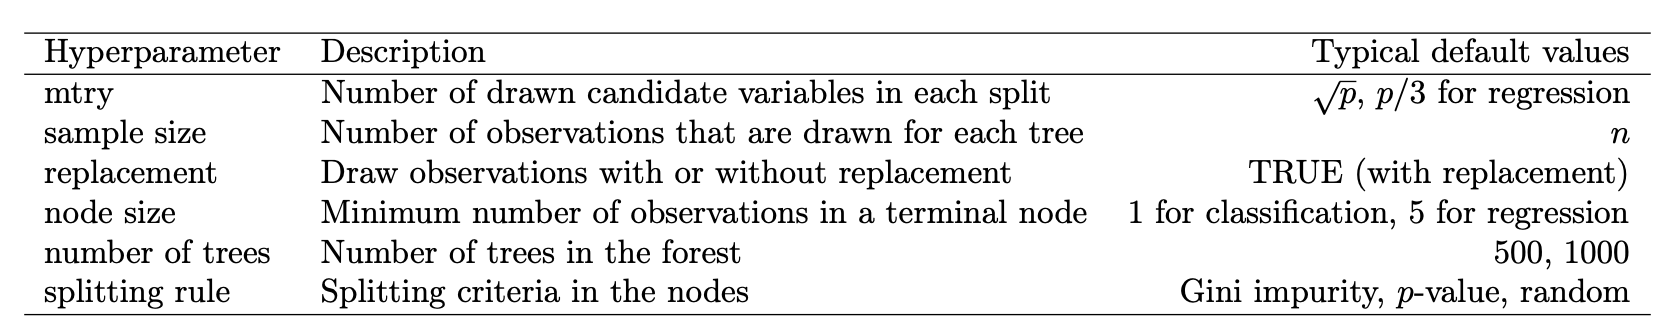

In [269]:
p = 149

grid = {'n_estimators': [100, 500, 1000],
               'max_features': [p, math.floor(math.sqrt(p)), math.floor(p/3)],
               'max_depth': [3, 5, 7, None],
               'random_state' : [42]}
grid


{'n_estimators': [100, 500, 1000],
 'max_features': [149, 12, 49],
 'max_depth': [3, 5, 7, None],
 'random_state': [42]}

In [271]:
rf = RandomForestRegressor()

rf_grid = GridSearchCV(estimator = rf, 
                               param_grid = grid,
                               scoring = my_scorer,
                               n_jobs = -1,
                               cv = 5, 
                               verbose = 0)


In [272]:
rf_grid.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, None],
                         'max_features': [149, 12, 49],
                         'n_estimators': [100, 500, 1000],
                         'random_state': [42]},
             scoring=make_scorer(custom_loss_function, greater_is_better=False))

In [273]:
rf_grid.best_params_


{'max_depth': None,
 'max_features': 49,
 'n_estimators': 500,
 'random_state': 42}

In [275]:
#5a. Rerun the RF model with new hyperparameters

new_model = RandomForestRegressor(n_estimators = 500, max_features = 49, max_depth = None, random_state = 42)
new_score = cross_val_score(new_model, X_train, y_train, scoring = my_scorer, cv=5)
print(np.mean(new_score))



-0.1428060623340539


In [276]:
#6. Ridge tuning:

random_grid = {'alpha': [x / 1000.0 for x in range(1, 1001, 2)]}

               
ridge = Ridge()
ridge_search = RandomizedSearchCV(estimator = ridge, 
                               param_distributions = random_grid, 
                               n_iter = 1000, 
                               cv = 5, 
                               verbose=0, 
                               random_state=42, 
                               scoring = my_scorer)

In [277]:
ridge_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=Ridge(), n_iter=1000,
                   param_distributions={'alpha': [0.001, 0.003, 0.005, 0.007,
                                                  0.009, 0.011, 0.013, 0.015,
                                                  0.017, 0.019, 0.021, 0.023,
                                                  0.025, 0.027, 0.029, 0.031,
                                                  0.033, 0.035, 0.037, 0.039,
                                                  0.041, 0.043, 0.045, 0.047,
                                                  0.049, 0.051, 0.053, 0.055,
                                                  0.057, 0.059, ...]},
                   random_state=42,
                   scoring=make_scorer(custom_loss_function, greater_is_better=False))

In [278]:
ridge_search.best_params_

{'alpha': 0.999}

In [279]:
ridge = Ridge(alpha = 0.999, random_state = 42)
ridge_score = cross_val_score(ridge, X_train, y_train, scoring = my_scorer, cv=5)
print(np.mean(ridge_score))


-0.1384067702036234


In [285]:
#7. Elastic Tuning

elastic = ElasticNet()

random_grid_elastic = {'alpha': [x / 10000 for x in range(1, 1001, 2)]}

elastic_search = RandomizedSearchCV(estimator = elastic, 
                               param_distributions = random_grid_elastic, 
                               n_iter = 1000, 
                               cv = 5, 
                               verbose=0, 
                               random_state=42, 
                               scoring = my_scorer)

In [286]:
elastic_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=ElasticNet(), n_iter=1000,
                   param_distributions={'alpha': [0.0001, 0.0003, 0.0005,
                                                  0.0007, 0.0009, 0.0011,
                                                  0.0013, 0.0015, 0.0017,
                                                  0.0019, 0.0021, 0.0023,
                                                  0.0025, 0.0027, 0.0029,
                                                  0.0031, 0.0033, 0.0035,
                                                  0.0037, 0.0039, 0.0041,
                                                  0.0043, 0.0045, 0.0047,
                                                  0.0049, 0.0051, 0.0053,
                                                  0.0055, 0.0057, 0.0059, ...]},
                   random_state=42,
                   scoring=make_scorer(custom_loss_function, greater_is_better=False))

In [287]:
elastic_search.best_params_

{'alpha': 0.0007}

In [290]:
elastic = ElasticNet(alpha = 0.0007, random_state = 42)
elastic_score = cross_val_score(elastic, X_train, y_train, scoring = my_scorer, cv=5)
print(np.mean(elastic_score))

-0.1355942359228795


In [306]:
#8. XGBoost Tuning (the hard one)

# GROUP 1: max_depth , min_child_weight

# GROUP 2: subsample, colsample_bytree

# GROUP 3: learning_rate

XGB = xgb.XGBRegressor()

random_grid_XGB = {'max_depth' : list(range(0, 25, 2)), 
                   'min_child_weight': [x/10 for x in range(0,10)],
                   'subsample': [1],
                   'colsample_bytree': [1],
                   'learning_rate': [0.3]}


In [309]:
XGB_search = RandomizedSearchCV(estimator = XGB, 
                               param_distributions = random_grid_XGB,
                               n_iter = 500,
                               cv = 5,
                               verbose = 0,
                               random_state = 42,
                               scoring = my_scorer,
                               n_jobs = -1)

In [310]:
XGB_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   n_iter=500, n_jobs=-1,
                   param_distributions={'colsample_bytree': [1],
                                        'learning_rate': [0.3],
                                        'max_depth': [0, 2, 4, 6, 8, 10, 12, 14,
                                                      16, 18, 20, 22, 24],
                                        'min_child_weight': [0.0, 0.1, 0.2, 0.3,
                                                             0.4, 0.5, 0.6, 0.7,
                                                             0.8, 0.9],
                                        'subsample': [1]},
                   random_state=42,
                   scoring=make_scorer(custom_loss_function, greater_is_better=False))

In [311]:
XGB_search.best_params_

{'subsample': 1,
 'min_child_weight': 0.0,
 'max_depth': 2,
 'learning_rate': 0.3,
 'colsample_bytree': 1}

In [313]:
#rerun with the chosen parameters from group 1
XGB = xgb.XGBRegressor(subsample = 1, min_child_weight = 0, max_depth = 2, learning_rate = 0.3, colsample_bytree = 1,
                      random_state = 42)

XGB_score = cross_val_score(XGB, X_train, y_train, scoring = my_scorer, cv = 5)

print(np.mean(XGB_score))

-0.14018582085035852


In [317]:
#Tune next group

XGB = xgb.XGBRegressor()

random_grid_XGB = {'max_depth' : [2], 
                   'min_child_weight': [0],
                   'subsample': list(x/100 for x in range(1,100)),
                   'colsample_bytree': list(x/100 for x in range(1,100)),
                   'learning_rate': [0.3]}


In [318]:
XGB_search = RandomizedSearchCV(estimator = XGB, 
                               param_distributions = random_grid_XGB,
                               n_iter = 500,
                               cv = 5,
                               verbose = 0,
                               random_state = 42,
                               scoring = my_scorer,
                               n_jobs = -1)

In [319]:
XGB_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                                             0.22, 0.23, 0.24,
                                                             0.25, 0.26, 0.27,
                                                             0.28, 0.29, 0.3, ...],
                                        'learning_rate': [0.3],
                                        'max_depth': [2],
                                        'min_child_weight': [0],
                                        'subsample': [0.01, 0.02, 0.03, 0.04,
                                                      0.05, 0.06, 0.07, 0.08,
                                                      0.09, 0.1, 0.11, 0.12,
                                                      0.13, 0.14, 0.15, 0.16,
                                                      0.17, 0.18, 0.19, 0.2,
                                                      0.21, 0.22, 0.23, 0.24,
                                                      0.25, 0.26, 0.27, 0.28,
                                                      0.29, 0.3, ...]},
                   random_state=42,
                   scoring=make_scorer(custom_loss_function, greater_is_better=False))

In [320]:
XGB_search.best_params_

{'subsample': 0.85,
 'min_child_weight': 0,
 'max_depth': 2,
 'learning_rate': 0.3,
 'colsample_bytree': 0.96}

In [321]:
XGB = xgb.XGBRegressor(subsample = 0.85, min_child_weight = 0, max_depth = 2, learning_rate = 0.3, colsample_bytree = 0.96,
                      random_state = 42)

XGB_score = cross_val_score(XGB, X_train, y_train, scoring = my_scorer, cv = 5)

print(np.mean(XGB_score))

#Score is very slightly better

-0.14004623079849848


In [329]:
#Tune next group

XGB = xgb.XGBRegressor()

random_grid_XGB = {'max_depth' : [2], 
                   'min_child_weight': [0],
                   'subsample': [0.85],
                   'colsample_bytree': [0.96],
                   'learning_rate': list(x/1000 for x in range(1,1000))}

In [330]:
XGB_search = RandomizedSearchCV(estimator = XGB, 
                               param_distributions = random_grid_XGB,
                               n_iter = 500,
                               cv = 5,
                               verbose = 0,
                               random_state = 42,
                               scoring = my_scorer,
                               n_jobs = -1)

In [331]:
XGB_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   param_distributions={'colsample_bytree': [0.96],
                                        'learning_rate': [0.001, 0.002, 0.003,
                                                          0.004, 0.005, 0.006,
                                                          0.007, 0.008, 0.009,
                                                          0.01, 0.011, 0.012,
                                                          0.013, 0.014, 0.015,
                                                          0.016, 0.017, 0.018,
                                                          0.019, 0.02, 0.021,
                                                          0.022, 0.023, 0.024,
                                                          0.025, 0.026, 0.027,
                                                          0.028, 0.029, 0.03, ...],
                                        'max_depth': [2],
                                        'min_child_weight': [0],
                                        'subsample': [0.85]},
                   random_state=42,
                   scoring=make_scorer(custom_loss_function, greater_is_better=False))

In [332]:
XGB_search.best_params_

{'subsample': 0.85,
 'min_child_weight': 0,
 'max_depth': 2,
 'learning_rate': 0.295,
 'colsample_bytree': 0.96}

In [333]:
XGB = xgb.XGBRegressor(subsample = 0.85, min_child_weight = 0, max_depth = 2, learning_rate = 0.295, colsample_bytree = 0.96,
                      random_state = 42)

XGB_score = cross_val_score(XGB, X_train, y_train, scoring = my_scorer, cv = 5)

print(np.mean(XGB_score))

#Score improved with each "round" of tuning?

-0.13899150475668595


In [334]:
#9. Rerun each model with our new, tuned hyperparameters

def cross_val_final(x,y):
    RF_model = RandomForestRegressor(n_estimators = 500, max_features = 49, max_depth = None, random_state = 42)
    score = cross_val_score(RF_model, x, y, scoring = my_scorer, cv = 5)
    print('Random Forest scores: ' + str(np.mean(score)))
    
    linear_model = Ridge(alpha = 0.999, random_state = 42)
    score2 = cross_val_score(linear_model, x, y, scoring = my_scorer, cv = 5)
    print('Ridge scores: ' + str(np.mean(score2)))
    
    elastic = ElasticNet(alpha = 0.0007, random_state = 42)
    score3 = cross_val_score(elastic, x, y, scoring = my_scorer, cv = 5)
    print('Elastic scores: ' + str(np.mean(score3)))
    
    boost = xgb.XGBRegressor(subsample = 0.85, min_child_weight = 0, max_depth = 2, learning_rate = 0.295, colsample_bytree = 0.96,
                      random_state = 42)
    score4 = cross_val_score(boost, x, y, scoring = my_scorer, cv = 5)
    print('XGBoost scores: ' + str(np.mean(score4)))

In [335]:
#Run final
cross_val_final(X_train, y_train)

Random Forest scores: -0.1428060623340539
Ridge scores: -0.1384067702036234
Elastic scores: -0.1355942359228795
XGBoost scores: -0.13899150475668595


In [336]:
#10. Blend

In [339]:
def blend(x, y, z):
    RF_model = RandomForestRegressor(n_estimators = 500, max_features = 49, max_depth = None, random_state = 42)
    RF_model.fit(x,y)
    prediction1 = RF_model.predict(z)
    
    linear_model = Ridge(alpha = 0.999, random_state = 42)
    linear_model.fit(x,y)
    prediction2 = linear_model.predict(z)
    
    elastic = ElasticNet(alpha = 0.0007, random_state = 42)
    elastic.fit(x,y)
    prediction3 = elastic.predict(z)
    
    boost = xgb.XGBRegressor(subsample = 0.85, min_child_weight = 0, max_depth = 2, learning_rate = 0.295, colsample_bytree = 0.96,
                      random_state = 42)
    boost.fit(x,y)
    prediction4 = boost.predict(z)
    
    final_prediction = (prediction1 + prediction2 + prediction3 + prediction4)/4
    
    final_prediction = np.exp(final_prediction) - 1
    
    return final_prediction
    

In [340]:
output = pd.DataFrame({'SalePrice': blend(X_train, y_train, X_test)}, index = test_original.Id.astype(int))
output.to_csv('HP_0709_v1.csv')

In [341]:
#This gets us to a score of .12748, our best score yet! 
#Next step: try using different combinations of models. Perhaps it isn't the best idea to use all 4 models. 

In [364]:
def blend_2(x, y, z):
    RF_model = RandomForestRegressor(n_estimators = 500, max_features = 49, max_depth = None, random_state = 42)
    RF_model.fit(x,y)
    prediction1 = RF_model.predict(z)
    prediction1 = np.exp(prediction1) - 1
    
    linear_model = Ridge(alpha = 0.999, random_state = 42)
    linear_model.fit(x,y)
    prediction2 = linear_model.predict(z)
    prediction2 = np.exp(prediction2) - 1

    
    elastic = ElasticNet(alpha = 0.0007, random_state = 42)
    elastic.fit(x,y)
    prediction3 = elastic.predict(z)
    prediction3 = np.exp(prediction3) - 1

    
    boost = xgb.XGBRegressor(subsample = 0.85, min_child_weight = 0, max_depth = 2, learning_rate = 0.295, colsample_bytree = 0.96,
                      random_state = 42)
    boost.fit(x,y)
    prediction4 = boost.predict(z)
    prediction4 = np.exp(prediction4) - 1
    
    return [prediction1, prediction2, prediction3, prediction4]

In [365]:
final_output = blend_2(X_train,y_train,X_test)

In [348]:
#now, we choose all combinations of 1, 2, 3 and 4 models. 

list

In [362]:
count = [1,2,3,4]
set = []
for x in count:
    for a in list(itertools.combinations(final_output, x)):
        set.append(a)

In [372]:
final = []

for x in set:
    final.append(sum(x)/len(x))

In [376]:
count = 1

for x in final:
    output = pd.DataFrame({'SalePrice': x}, index = test_original.Id.astype(int))
    output.to_csv(f'HP_0709_combination_v{count}.csv')
    count+=1

In [377]:
#all 15 combinations have been output to the files. Will need to run all into Kaggle to confirm what works best. 

In [378]:
#It turns out all 15 combinations were either equal or worse. For this iteration, the blend of 4 is the best outcome.

#Of interesting note - doing the blend and then converting back from log yields better results. We know this since
#we had a combination that was just the blend of all 4 (which yielded slightly worse results)

In [ ]:
#Note: it looks like the results of cross validation were relatively accurate in this case